# Modelling and Evaluation

## Objectives

*   Business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves_dataset/cherry-leaves/train
* inputs/cherry-leaves_dataset/cherry-leaves/test
* inputs/cherry-leaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Outputs

* Plot distribution of images across train, validation, and test sets.
* Perform image augmentation.
* Map class indices to alter prediction inference for labels.
* Create and train a machine learning model.
* Save the model.
* Plot learning curves to evaluate model performance.
* Evaluate the model using a pickle file.
* Make predictions on a randomly selected image file.

## Additional Comments

* No additional comments here. 

---


# Set The Data Directory & import libraries

## Import libraries

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [7]:
cwd= os.getcwd()

In [8]:
os.chdir('/workspace/pp5-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [9]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection-in-cherry-leaves'

## Set input directories

Sets the train, test and validation paths

In [10]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [11]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('The old version is already available, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

The old version is already available, please create a new version.


### Set label names

In [12]:
labels = os.listdir(train_path)
print('The label for the images are:', labels)

The label for the images are: ['healthy', 'powdery_mildew']


## Set image shape

Import saved image shape embedding

In [13]:
import joblib

version = 'v3'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




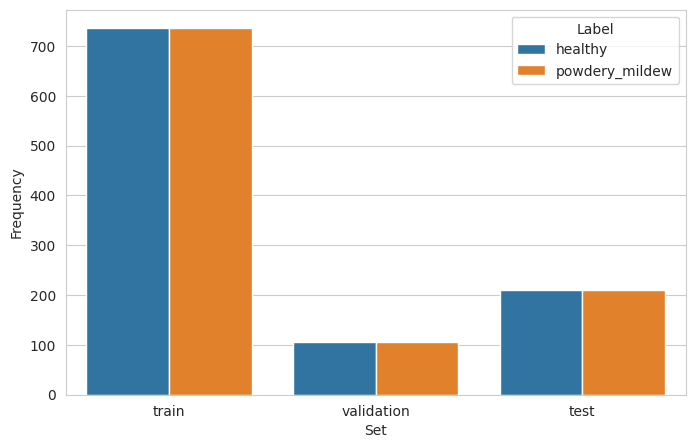

In [14]:
df_img_freq = pd.DataFrame([])

for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_img_freq = df_img_freq.append(
            pd.Series(
                data={
                    'Set': folder,
                    'Label': label,
                    'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
                }
            ),
            ignore_index=True
        )

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_img_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_dist.png', bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

### Import ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [16]:
augmented_img_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

* ### Augment the train image dataset

In [17]:
batch_size = 1 # was set to 1
train_set = augmented_img_data.flow_from_directory(
    train_path, 
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the validation image dataset

In [18]:
validation_img_data = ImageDataGenerator(rescale=1./255)
validation_set = validation_img_data.flow_from_directory(
    valid_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the test image dataset

In [19]:
test_img_data = ImageDataGenerator(rescale=1./255)
test_set = test_img_data.flow_from_directory(                       
    test_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_set.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot the augmented training images

(1, 256, 256, 3)


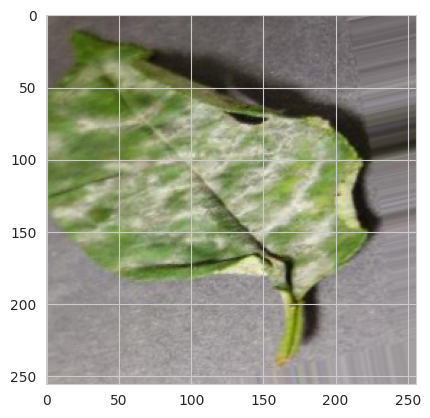

(1, 256, 256, 3)


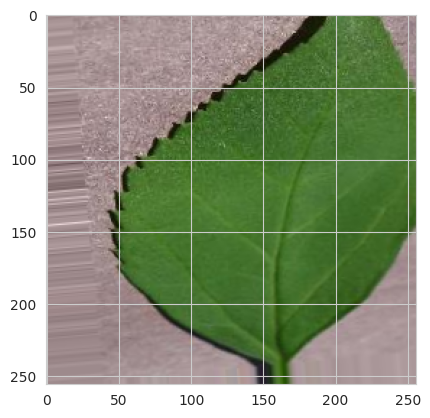

(1, 256, 256, 3)


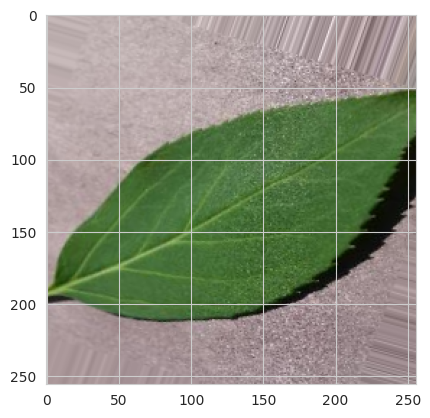

(1, 256, 256, 3)


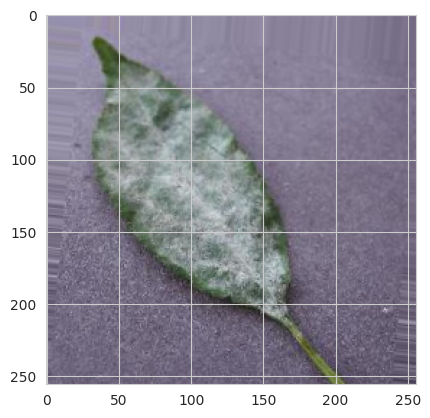

In [20]:
for _ in range(4):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot the augmented validation and test images

(1, 256, 256, 3)


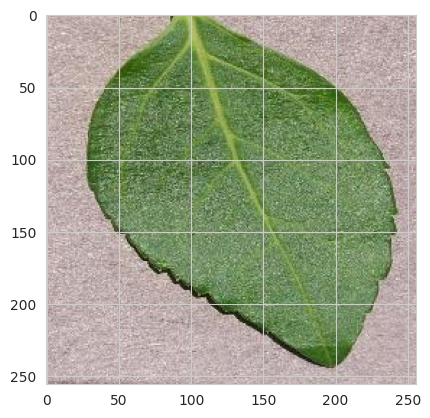

(1, 256, 256, 3)


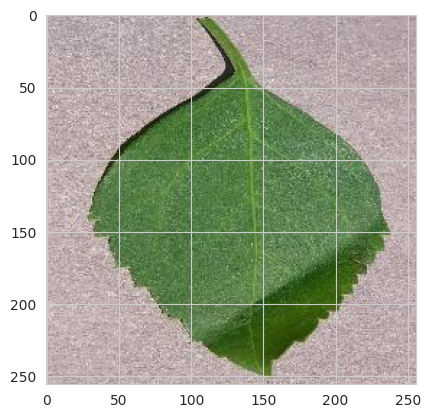

(1, 256, 256, 3)


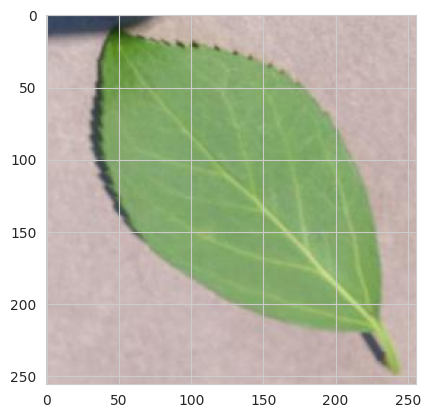

(1, 256, 256, 3)


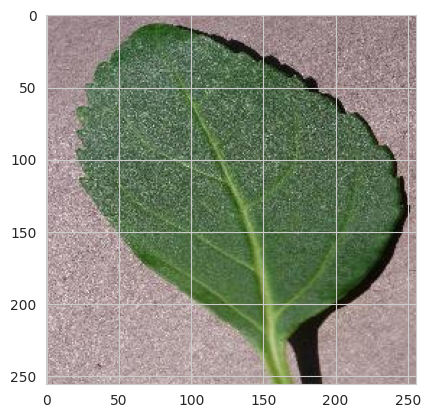

In [21]:
for _ in range(4):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(1, 256, 256, 3)


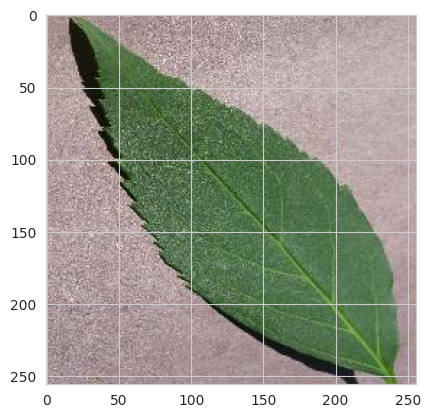

(1, 256, 256, 3)


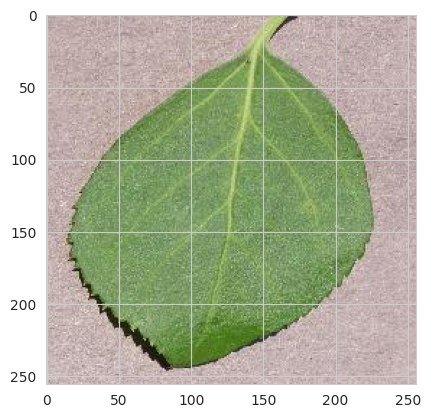

(1, 256, 256, 3)


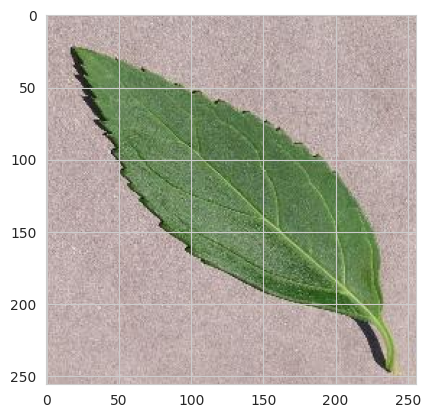

(1, 256, 256, 3)


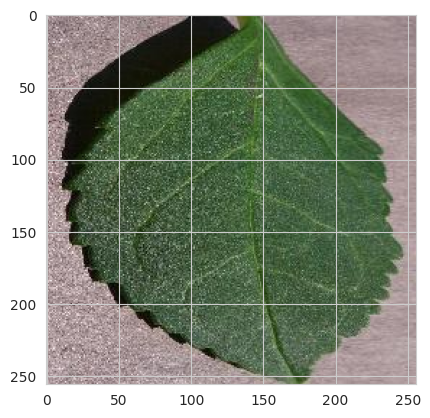

In [22]:
for _ in range(4):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Save the class_indices

In [23]:
joblib.dump(
    value=train_set.class_indices,
    filename=f"{file_path}/class_indices.pkl"
)

['outputs/v3/class_indices.pkl']

---

# Model creation

## Machine Learning Model

* ### Import model packages

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [25]:
def generate_tf_model():

    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Prevent overfitting
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # model.compile(loss='binary_crossentropy',
    #               optimizer='adam',
    #               metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model

* ### Generate and Model Summary 

In [26]:
model = generate_tf_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

2024-07-22 19:23:31.401864: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Model Early Stopping 

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

train_early_stop = EarlyStopping(monitor='val_loss', patience=4)


## Fit the model for model training

In [28]:
model = generate_tf_model()
history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=len(train_set.classes),
    validation_data=validation_set,
    callbacks=[train_early_stop],
    verbose=1
)

2024-07-22 19:23:39.801057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


1472/1472 [==============================] - 137s 92ms/step - loss: 0.5448 - accuracy: 0.7976 - val_loss: 0.7661 - val_accuracy: 0.9714
Epoch 2/25
1472/1472 [==============================] - 133s 90ms/step - loss: 0.4022 - accuracy: 0.9327 - val_loss: 0.1743 - val_accuracy: 0.9476
Epoch 3/25
1472/1472 [==============================] - 139s 94ms/step - loss: 0.4453 - accuracy: 0.9470 - val_loss: 0.0465 - val_accuracy: 0.9952
Epoch 4/25
1472/1472 [==============================] - 146s 99ms/step - loss: 0.3504 - accuracy: 0.9470 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 5/25
1472/1472 [==============================] - 146s 100ms/step - loss: 0.4449 - accuracy: 0.9586 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/25
1472/1472 [==============================] - 133s 91ms/step - loss: 0.4540 - accuracy: 0.9640 - val_loss: 1.9535e-05 - val_accuracy: 1.0000
Epoch 7/25
1472/1472 [==============================] - 133s 90ms/step - loss: 0.1958 - accuracy: 0.9769 - val_loss: 0.0084 

## Save model

In [29]:
model.save('outputs/v3/mildew_detector_model.h5')


# Model Performace

## Model learning curve - 1

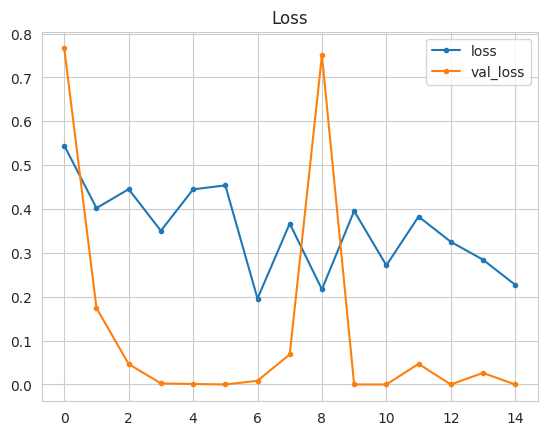

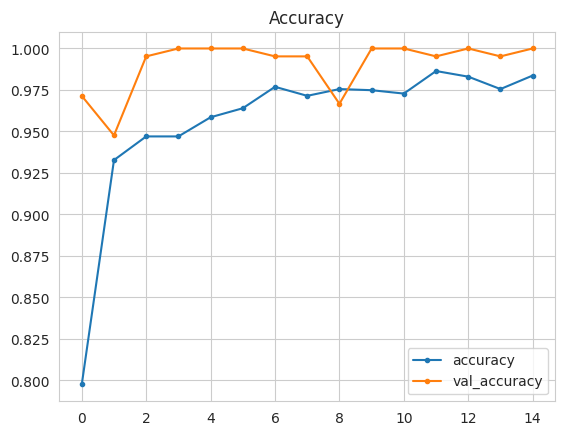

In [30]:
model_training_losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
model_training_losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
model_training_losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

## Model learning curve - 2

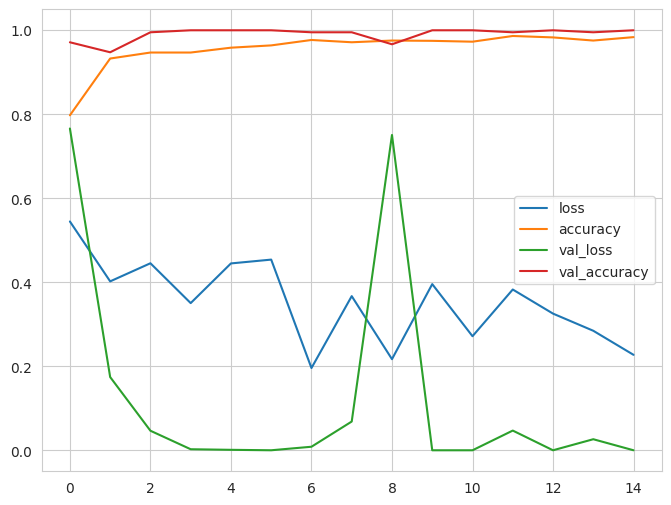

In [31]:
pd.DataFrame(model.history.history).plot(figsize=(8,6))

plt.savefig(f'{file_path}/model_combined.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load the saved model

In [32]:
from keras.models import load_model

model = load_model('outputs/v3/mildew_detector_model.h5')

Evaluate the model on the test set

In [33]:
evaluation = model.evaluate(test_set)

 25/422 [>.............................] - ETA: 7s - loss: 9.4339e-19 - accuracy: 1.0000

422/422 [==============================] - 8s 19ms/step - loss: 0.3220 - accuracy: 0.9858


### Save evaluation

In [34]:
joblib.dump(
    value=evaluation, filename=f"outputs/v3/model_evaluation.pkl"
    )

['outputs/v3/model_evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


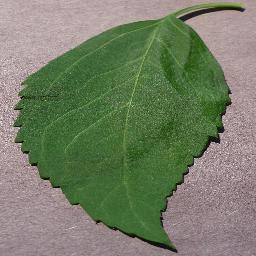

In [35]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select healthy - 0 or powdery mildew image - 1 

pil_img = image.load_img(
    test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
    target_size=img_shape,
    color_mode='rgb'
)
print(f'Image shape: {pil_img.size}, Image mode: {pil_img.mode}')
pil_img

Convert the image to an array & prepare for prediction

In [36]:
my_img = image.img_to_array(pil_img)
my_img = np.expand_dims(my_img, axis=0)/255
print(my_img.shape)

(1, 256, 256, 3)


Predict the class probabilities

In [37]:
proba_predictions = model.predict(my_img)[0, 0]

target_mapping = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_mapping[proba_predictions > 0.97]

if pred_class == target_mapping[0]:
    proba_predictions = 1 - proba_predictions

print(proba_predictions)
print(pred_class)

1.0
healthy


---

# Push files to Repo

## Push new files from this Session to the GitHub repo

* .gitignore

In [33]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [34]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_flipTB.JPG
	deleted:    inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842_180deg.JPG
	deleted:    inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/048daa26-d38c-477a-96b8-018b3d4ba386___JR_HL 9767_180deg.JPG
	deleted:    inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/077273c0-4325-45d9-995e-20b060eab6bf___JR_HL 9494_180deg.JPG
	deleted:    inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/077273c0-4325-45d9-995e-20b060eab6bf___JR_HL 9494_flipTB.JPG
	deleted:    inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/0f586b94-6c22-4cd7-8c47-4376c4d88226___JR_HL 9560.JP

* Git add

In [35]:
!git add .

* Git commit

In [36]:
!git commit -am "Add: New plots"

[main 4c762e0] Add: New plots
 2639 files changed, 135 insertions(+), 3274 deletions(-)
 rename inputs/cherry-leaves_dataset/cherry-leaves/{train => test}/healthy/00a8e886-d172-4261-85e2-780b3c50ad4d___JR_HL 4156.JPG (100%)
 delete mode 100644 inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_flipTB.JPG
 create mode 100644 inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/01958ee7-f585-4956-90aa-a40dc79102d4___JR_HL 9836_180deg.JPG
 rename inputs/cherry-leaves_dataset/cherry-leaves/{train => test}/healthy/02b90e70-80a6-415d-b6a8-07e22dead5c4___JR_HL 9892.JPG (100%)
 delete mode 100644 inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/048daa26-d38c-477a-96b8-018b3d4ba386___JR_HL 9767_180deg.JPG
 delete mode 100644 inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/077273c0-4325-45d9-995e-20b060eab6bf___JR_HL 9494_180deg.JPG
 delete mode 100644 inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/077273c0-4325-45

* Git Push

In [37]:
!git push

Enumerating objects: 1102, done.
Counting objects: 100% (1102/1102), done.
Delta compression using up to 32 threads
Compressing objects: 100% (1081/1081), done.
Writing objects: 100% (1086/1086), 50.05 MiB | 12.59 MiB/s, done.
Total 1086 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/NicoleJackson89/pp5-mildew-detection-in-cherry-leaves.git
   b8047cc..4c762e0  main -> main


---